In [11]:
import numpy as np
import errno
import os
from PIL import Image
import torch
import shutil
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.modules import Module
from torch.nn.modules.loss import _assert_no_grad
from tqdm import tqdm
tqdm.monitor_interval = 0

### Dataset
Download the OmniGlot dataset into a torch.Dataset. This will make it easy to batch load examples for training.

In [12]:
#Override __getitem__, __len__
cache = {}
class OmniglotDataset(data.Dataset):
    download_urls = [
        'https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip',
        'https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip'
    ]
    
    #copy the train/test/val splits from the Vinyals paper
    split_url = 'https://raw.githubusercontent.com/jakesnell/prototypical-networks/master/data/omniglot/splits/vinyals/'
    splits = {
        'test': split_url + 'test.txt',
        'train': split_url + 'train.txt',
        'trainval': split_url + 'trainval.txt',
        'val': split_url + 'val.txt',
    }
    splits_path = os.path.join('splits', 'vinyals')
    raw = 'raw'
    processed = 'data'

    def __init__(self, mode='train', root='../omniglot', download=True):
        '''
        @@mode: which of the sets to work with
        @@root: the directory where the dataset will be stored
        @@download: downloads the dataset
        '''
        super(OmniglotDataset, self).__init__()
        self.root = root

        if download:
            self.download()

        self.classes = self.get_current_classes(os.path.join(self.root, self.splits_path, mode + '.txt')) #for mode 
        self.items = self.find_items(os.path.join(self.root, self.processed), self.classes)
        self.idx_classes = self.index_classes(self.items)
        
        #y is a category label
        paths, self.y = zip(*[self.get_path_label(pl) for pl in range(len(self))]) 
        self.x = map(self.load_img, paths, range(len(paths))) #add the actual image to the Dataset object after rotation/resize
        self.x = list(self.x) #cast this to a list of images
    
    def __getitem__(self, idx):
        x = self.x[idx]
        return x, self.y[idx]

    def __len__(self):
        return len(self.items)
    
    
    def get_current_classes(self, fname):
        with open(fname) as f:
            classes = f.read().splitlines()
        return classes
    
    def find_items(self, root_dir, classes):
        '''
        returns a list of tuples with filename, label root, and its rotation
        '''
        retour = []
        #each image can have 4 rotations of the same image
        rots = ['/rot000', '/rot090', '/rot180', '/rot270']
        for (root, dirs, files) in os.walk(root_dir):
            for f in files:
                r = root.split('/')
                lr = len(r)
                label = r[lr - 2] + "/" + r[lr - 1]
                for rot in rots:
                    if label + rot in classes and (f.endswith("png")):
                        retour.extend([(f, label, root, rot)])
        print("== Dataset: Found %d items " % len(retour))
        return retour

    def index_classes(self, items):
        idx = {}
        for i in items:
            #if the image and rotation is not in the map, add it to the map (increasing in len)
            if (not i[1] + i[-1] in idx):  
                idx[i[1] + i[-1]] = len(idx)
        print("== Dataset: Found %d classes" % len(idx))
        return idx
    
    def get_path_label(self, index):
        filename = self.items[index][0]
        rot = self.items[index][-1]  
        img = str.join('/', [self.items[index][2], filename]) + rot
        target = self.idx_classes[self.items[index][1] + self.items[index][-1]]
        return img, target
    
    def _already_downloaded(self):
        return os.path.exists(os.path.join(self.root, self.processed))
    
    def download(self):
        '''
        Create and download the splits .txt
        Download raw zip'd omniglot data and unzip it. 
        '''
        import zipfile
        from six.moves import urllib

        if self._already_downloaded():
            return

        os.makedirs(os.path.join(self.root, self.splits_path))
        os.makedirs(os.path.join(self.root, self.raw))
        os.makedirs(os.path.join(self.root, self.processed))

        for k, url in self.splits.items():
            print('== Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[-1]
            file_path = os.path.join(self.root, self.splits_path, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())

        for url in self.download_urls:
            print('== Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.root, self.raw, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())
            orig_root = os.path.join(self.root, self.raw)
            print("== Unzip from " + file_path + " to " + orig_root)
            zip_ref = zipfile.ZipFile(file_path, 'r')
            zip_ref.extractall(orig_root)
            zip_ref.close()
            
        file_processed = os.path.join(self.root, self.processed)
        for p in ['images_background', 'images_evaluation']:
            for f in os.listdir(os.path.join(orig_root, p)):
                shutil.move(os.path.join(orig_root, p, f), file_processed)
            os.rmdir(os.path.join(orig_root, p))
        print("Download finished.")

    def load_img(self, path, idx):
        path, rot = path.split('/rot')
        if path in cache:
            x = cache[path]
        else:
            x = Image.open(path)
            cache[path] = x
        x = x.rotate(float(rot))   #rotate the image
        x = x.resize((28, 28))     #resize the image

        shape = 1, x.size[0], x.size[1]
        x = np.array(x, np.float32, copy=False)
        x = 1.0 - torch.from_numpy(x)
        x = x.transpose(0, 1).contiguous().view(shape)
        return x


In [13]:
x = OmniglotDataset()

== Dataset: Found 82240 items 
== Dataset: Found 4112 classes


### Data Sampler
A generator class for yielding a batch of indices with each training iteration.


In [14]:
class Sampler: 
    '''    
    Every iteration of the batch indices returns 'num_support' + 'num_query' samples
    for 'classes_per_it' random classes.
    
    __len__ is the number of iterations in an epoch.
    '''

    def __init__(self, labels, classes_per_it, num_samples, iterations):
        '''
        @@labels: an iterable containing all the labels for the current dataset
        @@classes_per_it: number of random classes per iteration
        @@num_samples: number of samples for each iteration for each class (support + query)
        @@iterations: number of iterations per epoch
        '''
        super(Sampler, self).__init__()
        self.labels = labels
        self.classes_per_it = classes_per_it
        self.sample_per_class = num_samples
        self.iterations = iterations

        self.classes, self.counts = np.unique(self.labels, return_counts=True)
        self.classes = torch.LongTensor(self.classes)

        self.idxs = range(len(self.labels))
        self.label_tens = np.empty((len(self.classes), max(self.counts)), dtype=int) * np.nan
        self.label_tens = torch.Tensor(self.label_tens)
        self.label_lens = torch.zeros_like(self.classes)
        for idx, label in enumerate(self.labels):
            label_idx = np.argwhere(self.classes == label)[0, 0]
            self.label_tens[label_idx, np.where(np.isnan(self.label_tens[label_idx]))[0][0]] = idx
            self.label_lens[label_idx] += 1

    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        sample_iter= self.sample_per_class
        class_iter = self.classes_per_it

        for it in range(self.iterations):
            batch_size = sample_iter * class_iter
            batch = torch.LongTensor(batch_size)
            c_idxs = torch.randperm(len(self.classes))[:class_iter]
            for i, c in enumerate(self.classes[c_idxs]):
                s = slice(i * sample_iter, (i + 1) * sample_iter)
                label_idx = np.argwhere(self.classes == c)[0, 0]
                sample_idxs = torch.randperm(self.label_lens[label_idx])[:sample_iter]
                batch[s] = self.label_tens[label_idx][sample_idxs]
            batch = batch[torch.randperm(len(batch))]   # batch is a slice of the data mapping a file to its class label
            yield batch

    def __len__(self):
        '''
        returns the number of iterations per epoch
        '''
        return self.iterations

### Prototypical Architecture 
based off of https://arxiv.org/pdf/1703.05175.pdf which provide a clean alternative to matching networks

In [26]:
def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.pow(x - y, 2).sum(2)

def prototypical_loss(inputs, target, n_support):
    '''
    Centroids in embedded space by averaging over the support and then calculates distance of each sample to these.
    
    Distance used in softmax to calculate log_probability for each query. 
    @@input: model final layer for a batch 
    @@target: class labels
    @@n_support: number of samples for centroids per class
    '''
    targs = target.data

    def supports(c):
        #for a class, choooses n_support examples
        return torch.nonzero(targs.eq(int(c)))[:n_support].squeeze() 

    classes = np.unique(targs)
    n_classes = len(classes)
    n_query = len(torch.nonzero(targs.eq(int(classes[0])))) - n_support   

    embedded_idxs = list(map(supports, classes))

    prototypes = torch.stack([inputs[i].mean(0) for i in embedded_idxs]) #calculates the prototypes from the embedded

    query_idxs = torch.stack(list(map(lambda c: torch.nonzero(targs.eq(int(c)))[n_support:], classes))).view(-1)
    query_points = inputs[query_idxs]
    dists = euclidean_dist(query_points, prototypes)

    log_p_y = F.log_softmax(-dists, dim=1).view(n_classes, n_query, -1) #log probs for the query points
    target_idx = torch.arange(0, n_classes).view(n_classes, 1, 1)
    target_idx = target_idx.expand(n_classes, n_query, 1).long().long()
    target_idx = Variable(target_idx, requires_grad=False) #no need for gradients on backward pass 

    loss = -log_p_y.gather(2, target_idx).squeeze().view(-1).mean() #mean cross entropy
    _, pred = log_p_y.max(2) #the largest probability class is our class prediction

    acc = torch.eq(pred, target_idx.squeeze()).float().mean()
    return loss, acc

class PrototypicalLoss(Module):
    def __init__(self, n_support):
        super(PrototypicalLoss, self).__init__()
        self.n_support = n_support
    
    def forward(self, input, target):
        '''
        http://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.forward
        forward pass at every call
        '''
        _assert_no_grad(target) #speeds up computation
        return prototypical_loss(input, target, self.n_support)


def conv_block(in_channels, out_channels):
    '''
    2d Convolution, BatchNorm, ReLu, MaxPool
    Each block is a 3X3 convolution, batch-normed, relu, followed by 2x2 maxpool
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

class ProtoTypicalNet(nn.Module):
    '''
    Architecture in the paper for embedding to a vector space for weighted KNN computation
    '''
    def __init__(self, input=1, hidden=64, output=64):
        super(ProtoTypicalNet, self).__init__()
        #embedded input examples into a space that can be clustered on
        self.encoder = nn.Sequential(
            conv_block(input, hidden),
            conv_block(hidden, hidden),
            conv_block(hidden, hidden),
            conv_block(hidden, output),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

In [16]:
class dotdict(dict):
     """dot.notation access to dictionary attributes"""
     __getattr__ = dict.get
     __setattr__ = dict.__setitem__
     __delattr__ = dict.__delitem__

### Train the network

In [17]:
opt_dict = {'dataset_root': '../omniglot', 'experiment_root': '../output', 'epochs': 5, 'learning_rate': 0.001,
           'lr_scheduler_step': 20, 'lr_scheduler_gamma': 0.5, 'iterations': 100, 'classes_per_it_tr': 60, 
           'num_support_tr': 5, 'num_query_tr': 5, 'classes_per_it_val': 5, 'num_support_val': 5,
           'num_query_val': 15, 'seed': 7}
options = dotdict(opt_dict)

In [18]:
if not os.path.exists(options.experiment_root):
        os.makedirs(options.experiment_root)
#Set the seed
torch.cuda.cudnn_enabled = False
np.random.seed(options.seed)
torch.manual_seed(options.seed)
#Setup the sampler for training & validation
train_dataset = OmniglotDataset(mode='train', root=options.dataset_root)
val_dataset = OmniglotDataset(mode='val', root=options.dataset_root)
tr_sampler = Sampler(labels=train_dataset.y, classes_per_it=options.classes_per_it_tr,
                     num_samples=options.num_support_tr + options.num_query_tr,
                     iterations=options.iterations)
val_sampler = Sampler(labels=val_dataset.y, classes_per_it=options.classes_per_it_val,
                     num_samples=options.num_support_val + options.num_query_val,
                     iterations=options.iterations)
#Run them into the torch dataloader
tr_dataloader = torch.utils.data.DataLoader(train_dataset, batch_sampler=tr_sampler)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_sampler=val_sampler)
#Setup the architecture and its optimizer, use ADAM and a learning rate schedule
model = ProtoTypicalNet()
optim = torch.optim.Adam(params=model.parameters(),lr=options.learning_rate)
lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer=optim, gamma=options.lr_scheduler_gamma,
                                              step_size=options.lr_scheduler_step)

== Dataset: Found 82240 items 
== Dataset: Found 4112 classes
== Dataset: Found 13760 items 
== Dataset: Found 688 classes


In [28]:
#actual model training step
train_loss = []
train_acc = []
val_loss = []
val_acc = []
best_acc = 0
best_model_path = os.path.join(options.experiment_root, 'best_model.pth')
last_model_path = os.path.join(options.experiment_root, 'last_model.pth')
for epoch in range(options.epochs):
    print('=== Epoch: {} ==='.format(epoch))
    tr_iter = iter(tr_dataloader)
    model.train()
    for batch in tqdm(tr_iter):
        optim.zero_grad()
        x, y = batch
        x, y = Variable(x), Variable(y)
        model_output = model(x)
        l, acc = prototypical_loss(model_output, target=y, n_support=options.num_support_tr)
        l.backward()
        optim.step()
        train_loss.append(l.data[0])
        train_acc.append(acc.data[0])
    avg_loss = np.mean(train_loss[-options.iterations:])
    avg_acc = np.mean(train_acc[-options.iterations:])
    print('Avg Train Loss: {}, Avg Train Acc: {}'.format(avg_loss, avg_acc))
    lr_schedule.step()
    if val_dataloader is None:
        continue
    #Validation after 1 epoch
    val_iter = iter(val_dataloader)
    model.eval()
    for batch in val_iter:
        x, y = batch
        x, y = Variable(x), Variable(y)
        model_output = model(x)
        l, acc = prototypical_loss(model_output, target=y, n_support=options.num_support_val)
        val_loss.append(l.data[0])
        val_acc.append(acc.data[0])
    avg_loss = np.mean(val_loss[-options.iterations:])
    avg_acc = np.mean(val_acc[-options.iterations:])
    bestval = ' (Best)' if avg_acc >= best_acc else ' (Best: {})'.format(best_acc)
    print('Avg Val Loss: {}, Avg Val Acc: {}{}'.format(avg_loss, avg_acc, bestval))
    if avg_acc >= best_acc:
        torch.save(model.state_dict(), best_model_path)
        best_acc = avg_acc
        best_state = model.state_dict()

torch.save(model.state_dict(), last_model_path)

for name in ['train_loss', 'train_acc', 'val_loss', 'val_acc']:
    save_list_to_file(os.path.join(opt.experiment_root, name + '.txt'), locals()[name])

  0%|          | 0/100 [00:00<?, ?it/s]

=== Epoch: 0 ===


100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


Avg Train Loss: 0.22566336795687675, Avg Train Acc: 0.9339666670560837


  0%|          | 0/100 [00:00<?, ?it/s]

Avg Val Loss: 0.03268261821332999, Avg Val Acc: 0.9896000039577484 (Best)
=== Epoch: 1 ===


100%|██████████| 100/100 [03:26<00:00,  2.06s/it]


Avg Train Loss: 0.17861799538135528, Avg Train Acc: 0.9470999950170517


  0%|          | 0/100 [00:00<?, ?it/s]

Avg Val Loss: 0.03261300092084184, Avg Val Acc: 0.9905333375930786 (Best)
=== Epoch: 2 ===


100%|██████████| 100/100 [03:27<00:00,  2.08s/it]


Avg Train Loss: 0.14907115936279297, Avg Train Acc: 0.9574333292245865


  0%|          | 0/100 [00:00<?, ?it/s]

Avg Val Loss: 0.027272660238913886, Avg Val Acc: 0.991466670036316 (Best)
=== Epoch: 3 ===


100%|██████████| 100/100 [03:13<00:00,  1.94s/it]


Avg Train Loss: 0.13432689033448697, Avg Train Acc: 0.9604999953508377


  0%|          | 0/100 [00:00<?, ?it/s]

Avg Val Loss: 0.021960864974007562, Avg Val Acc: 0.9938666701316834 (Best)
=== Epoch: 4 ===


100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Avg Train Loss: 0.11484382294118405, Avg Train Acc: 0.965600004196167
Avg Val Loss: 0.016837739227391922, Avg Val Acc: 0.9941333359479905 (Best)


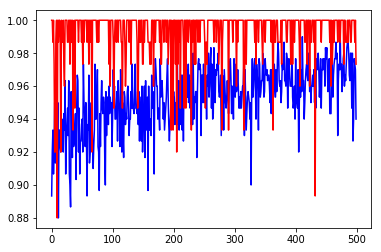

In [42]:
from matplotlib import pyplot as plt
t1 = np.arange(0.0, 500, 1)
plt.plot(t1, train_acc, 'b', val_acc, 'r')

Validation is also consistenly higher in acc with a lower loss than the training. This can be a product of batchnorm on the training phase, but I'm also compelled to believe that the model is underfitting with a presence of high bias. This can be worked on with increasing training time. (Going from 5 epochs to 50). 